In [1]:
# Importando as bibliotecas necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

## 1. Análise Exploratória de Dados (EDA)

In [2]:
# Carregando o dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalizando os valores dos pixels para o intervalo [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Reshape dos dados para o formato (n_samples, n_features)
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Print das dimensões dos datasets
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (60000, 784)
x_test shape: (10000, 784)


## 2. Construção e Treinamento do Autoencoder

In [3]:
# Definindo a dimensão do código codificado
encoding_dim = 32

# Definindo a camada de entrada
input_img = Input(shape=(784,))

# Definindo a camada de codificação
encoded = Dense(encoding_dim, activation='relu')(input_img)

# Definindo a camada de decodificação
decoded = Dense(784, activation='sigmoid')(encoded)

# Definindo o autoencoder
autoencoder = Model(input_img, decoded)

# Definindo o codificador
encoder = Model(input_img, encoded)

# Definindo o decodificador
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

# Compilando o autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [4]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Treinando o autoencoder
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[early_stopping])

Epoch 1/100
235/235 [==============================] - 1s 4ms/step - loss: 0.4206 - val_loss: 0.3466
Epoch 2/100
235/235 [==============================] - 1s 4ms/step - loss: 0.3294 - val_loss: 0.3206
Epoch 3/100
235/235 [==============================] - 1s 4ms/step - loss: 0.3119 - val_loss: 0.3079
Epoch 4/100
235/235 [==============================] - 1s 4ms/step - loss: 0.3022 - val_loss: 0.3007
Epoch 5/100
235/235 [==============================] - 1s 4ms/step - loss: 0.2962 - val_loss: 0.2957
Epoch 6/100
235/235 [==============================] - 1s 4ms/step - loss: 0.2920 - val_loss: 0.2926
Epoch 7/100
235/235 [==============================] - 1s 4ms/step - loss: 0.2891 - val_loss: 0.2899
Epoch 8/100
235/235 [==============================] - 1s 4ms/step - loss: 0.2872 - val_loss: 0.2887
Epoch 9/100
235/235 [==============================] - 1s 4ms/step - loss: 0.2861 - val_loss: 0.2880
Epoch 10/100
235/235 [==============================] - 1s 4ms/step - loss: 0.2855 - val_lo

## 3. Visualização do Resultado do Decoder

313/313 [==============================] - 0s 756us/step


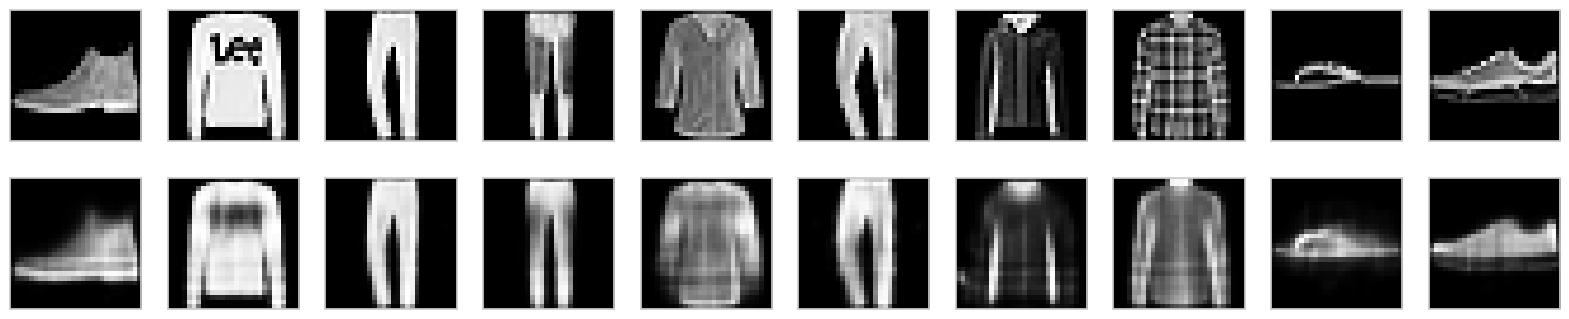

In [5]:
# Codificando e decodificando algumas imagens do conjunto de teste
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# Plotando as imagens originais e as imagens reconstruídas
n = 10  # número de imagens para exibir
plt.figure(figsize=(20, 4))
for i in range(n):
    # imagens originais
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # imagens reconstruídas
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 4. Construção e Comparação de Classificadores RandomForest e XgBoost

In [6]:
# Construindo e treinando o classificador RandomForest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
rf_classifier.fit(x_train, y_train)

# Avaliando o classificador RandomForest
rf_predictions = rf_classifier.predict(x_test)
print('RandomForest Classifier:', classification_report(y_test, rf_predictions))

RandomForest Classifier:               precision    recall  f1-score   support

           0       0.82      0.86      0.84      1000
           1       0.99      0.96      0.98      1000
           2       0.77      0.81      0.79      1000
           3       0.88      0.90      0.89      1000
           4       0.77      0.82      0.79      1000
           5       0.98      0.96      0.97      1000
           6       0.71      0.58      0.64      1000
           7       0.93      0.95      0.94      1000
           8       0.96      0.97      0.97      1000
           9       0.95      0.94      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.87     10000
weighted avg       0.88      0.88      0.87     10000



In [7]:
# Construindo e treinando o classificador XgBoost
xgb_classifier = XGBClassifier(random_state=RANDOM_SEED)
xgb_classifier.fit(x_train, y_train)

# Avaliando o classificador XgBoost
xgb_predictions = xgb_classifier.predict(x_test)
print('XgBoost Classifier:', classification_report(y_test, xgb_predictions))

XgBoost Classifier:               precision    recall  f1-score   support

           0       0.84      0.87      0.86      1000
           1       0.99      0.97      0.98      1000
           2       0.81      0.83      0.82      1000
           3       0.90      0.91      0.91      1000
           4       0.82      0.84      0.83      1000
           5       0.99      0.97      0.98      1000
           6       0.74      0.68      0.71      1000
           7       0.95      0.97      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



## 5. Visualização de Dados com TSNE

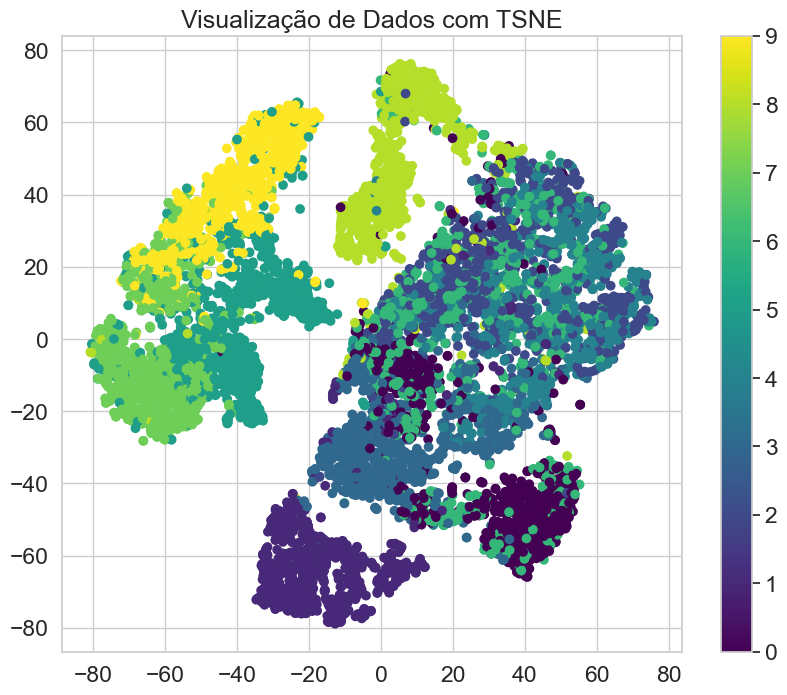

In [8]:
# Reduzindo a dimensionalidade dos dados com TSNE
tsne = TSNE(n_components=2, random_state=RANDOM_SEED)
x_test_2D = tsne.fit_transform(x_test)

# Plotando os dados
plt.figure(figsize=(10, 8))
scatter = plt.scatter(x_test_2D[:, 0], x_test_2D[:, 1], c=y_test, cmap='viridis')
plt.colorbar(scatter)
plt.title('Visualização de Dados com TSNE')
plt.show()

## 6. Repetição do Processo com um Autoencoder Convolucional

In [9]:
# Carregando o dataset novamente
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalizando os valores dos pixels para o intervalo [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Adicionando uma dimensão extra para os canais
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Print das dimensões dos datasets
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)


In [10]:
# Definindo a arquitetura do autoencoder convolucional
input_img = Input(shape=(28, 28, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder_conv = Model(input_img, decoded)
autoencoder_conv.compile(optimizer='adam', loss='binary_crossentropy')

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Treinando o autoencoder convolucional
autoencoder_conv.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[early_stopping]
                )

Epoch 1/100
235/235 [==============================] - 32s 135ms/step - loss: 0.4018 - val_loss: 0.3249
Epoch 2/100
235/235 [==============================] - 31s 134ms/step - loss: 0.3143 - val_loss: 0.3099
Epoch 3/100
235/235 [==============================] - 31s 131ms/step - loss: 0.3046 - val_loss: 0.3039
Epoch 4/100
235/235 [==============================] - 32s 136ms/step - loss: 0.3004 - val_loss: 0.3008
Epoch 5/100
235/235 [==============================] - 32s 135ms/step - loss: 0.2978 - val_loss: 0.2986
Epoch 6/100
235/235 [==============================] - 31s 132ms/step - loss: 0.2958 - val_loss: 0.2971
Epoch 7/100
235/235 [==============================] - 31s 130ms/step - loss: 0.2943 - val_loss: 0.2960
Epoch 8/100
235/235 [==============================] - 31s 131ms/step - loss: 0.2930 - val_loss: 0.2944
Epoch 9/100
235/235 [==============================] - 30s 127ms/step - loss: 0.2919 - val_loss: 0.2932
Epoch 10/100
235/235 [==============================] - 30s 126m

## 7. Comparação dos Resultados (loss) do Autoencoder Simplificado e Convolucional

In [18]:
# Calculando a perda do autoencoder simplificado
simplified_autoencoder_loss = autoencoder.evaluate(x_test.reshape(-1, 784), x_test.reshape(-1, 784), verbose=0)

# Calculando a perda do autoencoder convolucional
convolutional_autoencoder_loss = autoencoder_conv.evaluate(x_test, x_test, verbose=0)

print(f'Perda do Autoencoder Simplificado: {simplified_autoencoder_loss}')
print(f'Perda do Autoencoder Convolucional: {convolutional_autoencoder_loss}')


Perda do Autoencoder Simplificado: 0.2835598587989807
Perda do Autoencoder Convolucional: 0.28082942962646484


## 8. Utilização da Última Camada de Max Pooling como Feature para um Classificador

In [21]:
# Extraindo as features da última camada de max pooling
feature_extractor = Model(inputs=autoencoder_conv.input, outputs=autoencoder_conv.get_layer('max_pooling2d').output)
x_train_features = feature_extractor.predict(x_train)
x_test_features = feature_extractor.predict(x_test)

# Redimensionando as features para o formato (n_samples, n_features)
x_train_features = x_train_features.reshape((len(x_train_features), np.prod(x_train_features.shape[1:])))
x_test_features = x_test_features.reshape((len(x_test_features), np.prod(x_test_features.shape[1:])))

# Construindo e treinando o classificador RandomForest com as features extraídas
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
rf_classifier.fit(x_train_features, y_train)

# Avaliando o classificador RandomForest
rf_predictions = rf_classifier.predict(x_test_features)
print('RandomForest Classifier:', classification_report(y_test, rf_predictions))


313/313 [==============================] - 1s 2ms/step
RandomForest Classifier:               precision    recall  f1-score   support

           0       0.84      0.86      0.85      1000
           1       0.99      0.97      0.98      1000
           2       0.80      0.82      0.81      1000
           3       0.88      0.91      0.89      1000
           4       0.79      0.84      0.81      1000
           5       0.97      0.96      0.97      1000
           6       0.73      0.62      0.67      1000
           7       0.93      0.96      0.94      1000
           8       0.96      0.98      0.97      1000
           9       0.96      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



## 9. Visualização de Dados com TSNE (utilizando as features extraídas)

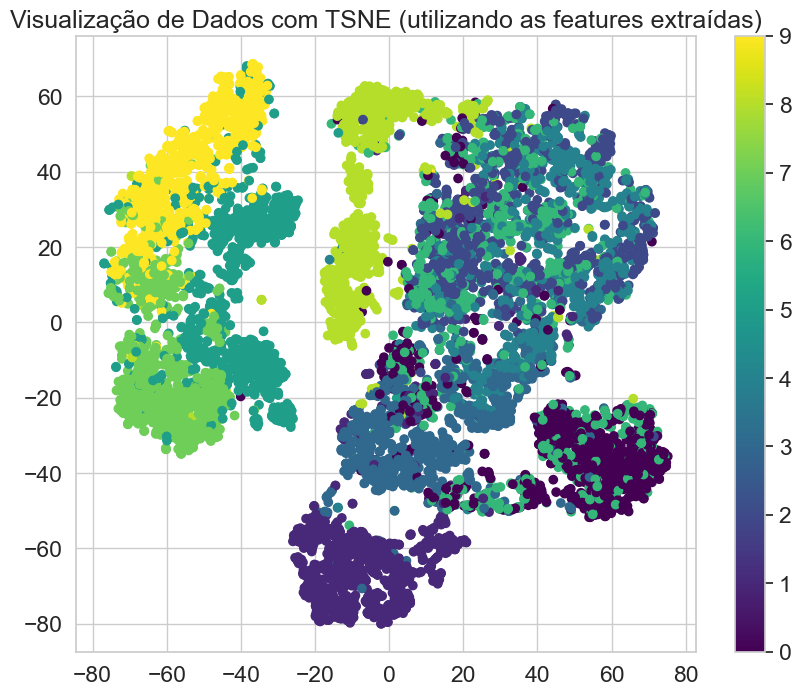

In [22]:
# Reduzindo a dimensionalidade das features com TSNE
x_test_features_2D = tsne.fit_transform(x_test_features)

# Plotando os dados
plt.figure(figsize=(10, 8))
scatter = plt.scatter(x_test_features_2D[:, 0], x_test_features_2D[:, 1], c=y_test, cmap='viridis')
plt.colorbar(scatter)
plt.title('Visualização de Dados com TSNE (utilizando as features extraídas)')
plt.show()